<a href="https://colab.research.google.com/github/evan-grinalds/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Copy_of_LS_DS17_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/evan-grinalds/Unit-2-Build-Tesla/master/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Clean the data

In [2]:
import pandas as pd

df = pd.read_csv(DATA_PATH+'model_s_whole.csv')

print(df.shape)
df

(200, 7)


,year,car,battery,ludacris_mode,all_wheel_drive,mileage,price
0,2013,Model S,60,No,No,82851 mi.,27995
1,2018,Model S,100,No,Yes,5357 mi.,57992
2,2012,Model S,60,No,No,85478 mi.,24499
3,2017,Model S,100,No,Yes,32593 mi.,59980
4,2016,Model S,60,No,Yes,28418 mi.,49560
...,...,...,...,...,...,...,...
195,2014,Model S,60,No,No,25444 mi.,39590
196,2016,Model S,100,Yes,Yes,33719 mi.,67990
197,2020,Model S,100,No,No,1527 mi.,83900
198,2016,Model S,75,No,No,50600 mi.,40500


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read train_features.csv
train = pd.read_csv(DATA_PATH+'model_s_train_features.csv')
                
# Read test_features.csv
test = pd.read_csv(DATA_PATH+'model_s_test_features.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20) 

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [4]:
# Remove symbols, convert to integer
train['mileage'] = (
train['mileage']
.str.replace('mi.','')
.astype(int)
)

val['mileage'] = (
val['mileage']
.str.replace('mi.','')
.astype(int)
)

test['mileage'] = (
test['mileage']
.str.replace('mi.','')
.astype(int)
)

df['mileage'] = (
df['mileage']
.str.replace('mi.','')
.astype(int)
)

In [5]:
train.head()

,year,car,battery,ludacris_mode,all_wheel_drive,mileage,price
81,2016,Model S,90,No,Yes,26393,52999
45,2017,Model S,100,Yes,Yes,10028,80990
34,2016,Model S,60,No,No,41591,42999
56,2016,Model S,90,Yes,Yes,25280,63990
94,2016,Model S,90,No,Yes,22942,70750


### Visualizations 


In [6]:
import plotly.express as px
px.scatter(df, x='year', y='price', trendline='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Feature Selection


In [20]:
# Arrange data into X features matrix and y target vector
feature = ['year', 'battery', 'ludacris_mode', 'all_wheel_drive', 'mileage']
target = 'price'
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [8]:
# Check shape before encoding
# X_train.shape, X_val.shape, X_test.shape

In [25]:
#import category_encoders as ce

#encoder = ce.OneHotEncoder(use_cat_names=True)
#X_train = encoder.fit_transform(X_train)
#X_val = encoder.transform(X_val)
#X_test = encoder.transform(X_test)

In [26]:
# Check shape after encoding
# X_train.shape, X_val.shape, X_test.shape

((80, 8), (20, 8), (100, 8))

In [28]:
# X_train.head()

,year,car_Model S,battery,ludacris_mode_No,ludacris_mode_Yes,all_wheel_drive_Yes,all_wheel_drive_No,mileage
43,2015,1,75,1,0,1,0,47768
2,2012,1,60,1,0,0,1,85478
73,2013,1,60,0,1,0,1,52646
16,2013,1,60,1,0,0,1,52876
35,2018,1,100,1,0,1,0,13427


### Baseline

In [9]:
pd.options.display.float_format = '{:,.0f}'.format
df['price'].describe()

count      200
mean    47,691
std     15,380
min     24,499
25%     35,000
50%     44,585
75%     57,247
max     92,900
Name: price, dtype: float64

In [10]:
guess = df['price'].mean()

In [11]:
guess

47690.6

In [12]:
errors = guess - df['price']

In [13]:
errors

0      19,696
1     -10,301
2      23,192
3     -12,289
4      -1,869
        ...  
195     8,101
196   -20,299
197   -36,209
198     7,191
199     7,791
Name: price, Length: 200, dtype: float64

In [14]:
mean_absolute_error = errors.abs().mean()

In [15]:
print(f'If we just guessed every Tesla Model S sold for ${guess:,.0f},')
print(f'we would be off by ${mean_absolute_error:,.0f} on average.')

If we just guessed every Tesla Model S sold for $47,691,
we would be off by $12,357 on average.


### Ridge Regression

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.BinaryEncoder(), 
    KNNImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'knnimputer__n_neighbors': [3,4,5,6,7,8], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1,8,9,10,15], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0920s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 244 tas

In [33]:
print('Best hyperparameters', search.best_params_)
print('Test MAE: $', -search.best_score_)

Best hyperparameters {'selectkbest__k': 3, 'ridge__alpha': 15, 'knnimputer__n_neighbors': 5}
Test MAE: $ 5903.91118735083


### Random Forest

In [39]:
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

In [30]:
print('Best hyperparameters', search.best_params_)
print('Test MAE: $', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.10518974220176058, 'randomforestregressor__n_estimators': 491, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 37}
Test MAE: $ 4262.760692464359


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    GradientBoostingRegressor(random_state=42)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'gradientboostingregressor__max_depth': [5, 10, 15, 20, None], 
    'gradientboostingregressor__loss': ['ls','lad','huber','quantile'], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train);

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Test MAE: $', -search.best_score_)

### XG Boost

In [35]:
from xgboost import XGBRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    XGBRegressor(random_state=42,n_jobs=-1)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__learning_rate': [.03, 0.05, .07 ,0.13,0.2],
    'xgbregressor__max_depth': [5, 6, 7],}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

[16:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


In [36]:
print('Best hyperparameters', search.best_params_)
print('Test MAE: $', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 32, 'xgbregressor__learning_rate': 0.13, 'xgbregressor__max_depth': 7}
Test MAE: $ 4625.539697265625


### Permutation Importances

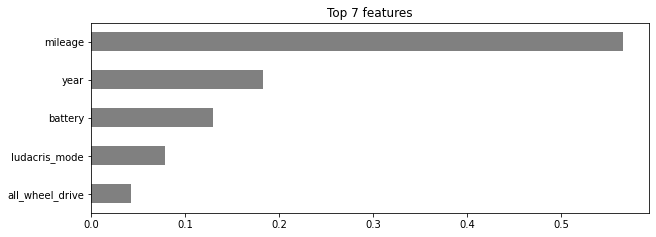

In [55]:
from sklearn.ensemble import RandomForestClassifier
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 7
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### eli5 Library

In [60]:
import eli5
from eli5.sklearn import PermutationImportance

# Ignore warnings

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)



feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0700 ± 0.0490,battery
0.0400 ± 0.0748,year
0.0300 ± 0.0490,ludacris_mode
0.0200 ± 0.0800,mileage
0 ± 0.0000,all_wheel_drive
